# Posterior inference on a birth-death model

In [8]:
from collections import defaultdict

import jax.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from jax import jit
from jax.config import config
from mcmc_diagnostics import estimate_ess
from scipy.stats import gamma, lognorm, norm

from gcdyn import models, mutators, poisson, utils
from gcdyn.mcmc import Parameter, mh_chain

config.update("jax_enable_x64", True)

## Set up truth

In [9]:
true_parameters = {
    "birth_response": poisson.SigmoidResponse(1.0, 5.0, 2.0, 0.5),
    "death_response": poisson.ConstantResponse(1.3),
    "mutation_response": poisson.ConstantResponse(1.2),
    "mutator": mutators.DiscreteMutator(
        state_space=(1, 3, 5, 7, 9),
        transition_matrix=np.array(
            [
                [3, 2, 2, 1, 1],
                [2, 3, 2, 1, 1],
                [1, 2, 3, 2, 1],
                [1, 1, 2, 3, 2],
                [1, 1, 2, 2, 3],
            ]
        )
        / 9,
    ),
    "extant_sampling_probability": 1,
    "extinct_sampling_probability": 0,
}

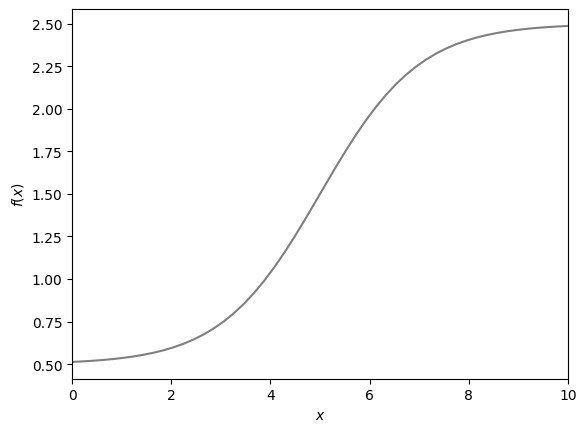

In [10]:
utils.plot_responses(true_parameters["birth_response"], x_range=(0, 10))

## Sample trees

In [11]:
PRESENT_TIME = 4

trees = utils.sample_trees(
    n=10,
    t=PRESENT_TIME,
    init_x=1,
    **true_parameters,
    seed=10,
    min_survivors=1,
    prune=True,
)

Sampling trees...


  0%|          | 0/10 [00:00<?, ?it/s]

Notice: obtained error 'number of survivors 0 is less than min_survivors=1' 65 times.
Success: average of 262.1 nodes per tree, over 10 trees.
Type 1 exists in 157 nodes
Type 3 exists in 213 nodes
Type 5 exists in 463 nodes
Type 7 exists in 624 nodes
Type 9 exists in 1164 nodes

 After pruning: average of 120.2 nodes per tree, and average of 43.1 leaves per tree, over 10 trees.
Type 1 exists in 73 nodes
Type 3 exists in 99 nodes
Type 5 exists in 178 nodes
Type 7 exists in 308 nodes
Type 9 exists in 544 nodes


## Configure priors and proposals

In [12]:
XSCALE_PRIOR_SHAPE = 2
XSCALE_PRIOR_SCALE = 1
XSHIFT_PRIOR_MEAN = 5
XSHIFT_PRIOR_SD = 1
YSCALE_PRIOR_SHAPE = 2
YSCALE_PRIOR_SCALE = 1
DR_PRIOR_SHAPE = 3.5
DR_PRIOR_SCALE = 1 / 3

XSCALE_PROPOSAL_SD = 3
XSHIFT_PROPOSAL_SD = 2
YSCALE_PROPOSAL_SD = 1
DR_PROPOSAL_SD = 1 / 2

mcmc_parameters = dict(
    xscale=Parameter(
        prior_log_density=gamma(a=XSCALE_PRIOR_SHAPE, scale=XSCALE_PRIOR_SCALE).logpdf,
        prior_generator=lambda n: gamma(
            a=XSCALE_PRIOR_SHAPE, scale=XSCALE_PRIOR_SCALE
        ).rvs(n),
        proposal_log_density=lambda p, c: lognorm(scale=c, s=XSCALE_PROPOSAL_SD).logpdf(
            p
        ),
        proposal_generator=lambda c: lognorm(scale=c, s=XSCALE_PROPOSAL_SD).rvs(1),
    ),
    xshift=Parameter(
        prior_log_density=norm(loc=XSHIFT_PRIOR_MEAN, scale=XSHIFT_PRIOR_SD).logpdf,
        prior_generator=lambda n: norm(
            loc=XSHIFT_PRIOR_MEAN, scale=XSHIFT_PRIOR_SD
        ).rvs(n),
        proposal_log_density=lambda p, c: norm(loc=c, scale=XSHIFT_PROPOSAL_SD).logpdf(
            p
        ),
        proposal_generator=lambda c: norm(loc=c, scale=XSHIFT_PROPOSAL_SD).rvs(1),
    ),
    yscale=Parameter(
        prior_log_density=gamma(a=YSCALE_PRIOR_SHAPE, scale=YSCALE_PRIOR_SCALE).logpdf,
        prior_generator=lambda n: gamma(
            a=YSCALE_PRIOR_SHAPE, scale=YSCALE_PRIOR_SCALE
        ).rvs(n),
        proposal_log_density=lambda p, c: lognorm(scale=c, s=YSCALE_PROPOSAL_SD).logpdf(
            p
        ),
        proposal_generator=lambda c: lognorm(scale=c, s=YSCALE_PROPOSAL_SD).rvs(1),
    ),
    yshift=Parameter(
        prior_log_density=lambda y: y == true_parameters["birth_response"].yshift,
        prior_generator=lambda n: np.ones(n) * true_parameters["birth_response"].yshift,
        proposal_log_density=lambda p, c: p == true_parameters["birth_response"].yshift,
        proposal_generator=lambda c: true_parameters["birth_response"].yshift,
    ),
    death_rate=Parameter(
        prior_log_density=gamma(a=DR_PRIOR_SHAPE, scale=DR_PRIOR_SCALE).logpdf,
        prior_generator=lambda n: gamma(a=DR_PRIOR_SHAPE, scale=DR_PRIOR_SCALE).rvs(n),
        proposal_log_density=lambda p, c: lognorm(scale=c, s=DR_PROPOSAL_SD).logpdf(p),
        proposal_generator=lambda c: lognorm(scale=c, s=DR_PROPOSAL_SD).rvs(1),
    ),
)

## Configure likelihood

In [13]:
@jit
def log_likelihood(death_rate, **birth_params):
    return models.stadler_appx_log_likelihood(
        trees=trees,
        birth_response=poisson.SigmoidResponse(**birth_params),
        death_response=poisson.ConstantResponse(death_rate),
        mutation_response=true_parameters["mutation_response"],
        mutator=true_parameters["mutator"],
        extant_sampling_probability=true_parameters["extant_sampling_probability"],
        extinct_sampling_probability=true_parameters["extinct_sampling_probability"],
        present_time=PRESENT_TIME,
    )

## Run MCMC

In [14]:
posterior_samples, stats = mh_chain(
    length=2000,
    parameters=mcmc_parameters,
    log_likelihood=log_likelihood,
)

Running MH chain...


  0%|          | 0/2000 [00:00<?, ?it/s]

## Traceplots

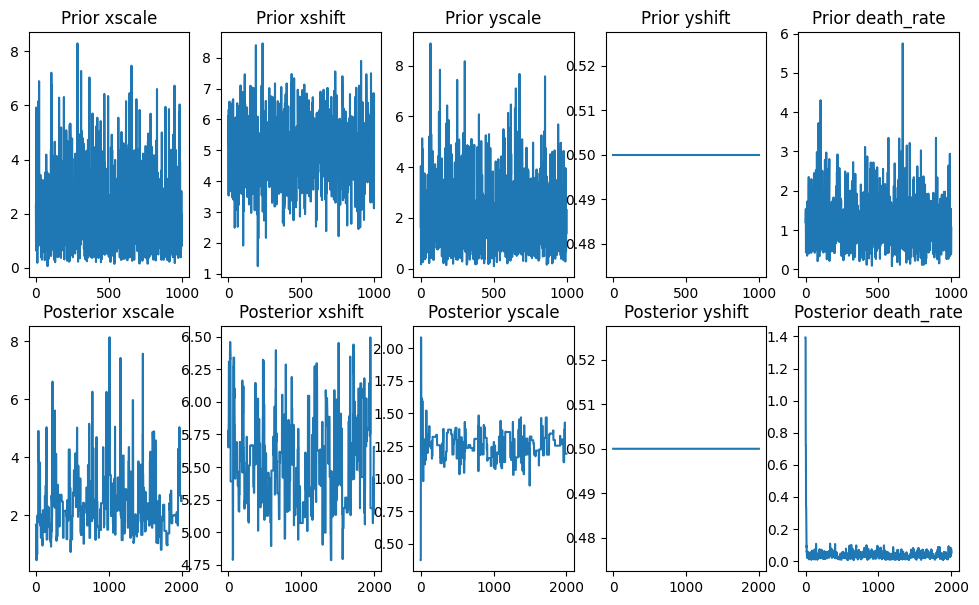

In [15]:
prior_samples = {
    name: param.prior_generator(1000) for name, param in mcmc_parameters.items()
}

fig, axes = plt.subplots(2, len(posterior_samples))
fig.set_figwidth(12)
fig.set_figheight(7)

for i, param in enumerate(posterior_samples):
    sns.lineplot(prior_samples[param], ax=axes[0, i])
    axes[0, i].set_title(f"Prior {param}")
    sns.lineplot(posterior_samples[param], ax=axes[1, i])
    axes[1, i].set_title(f"Posterior {param}")

plt.show()

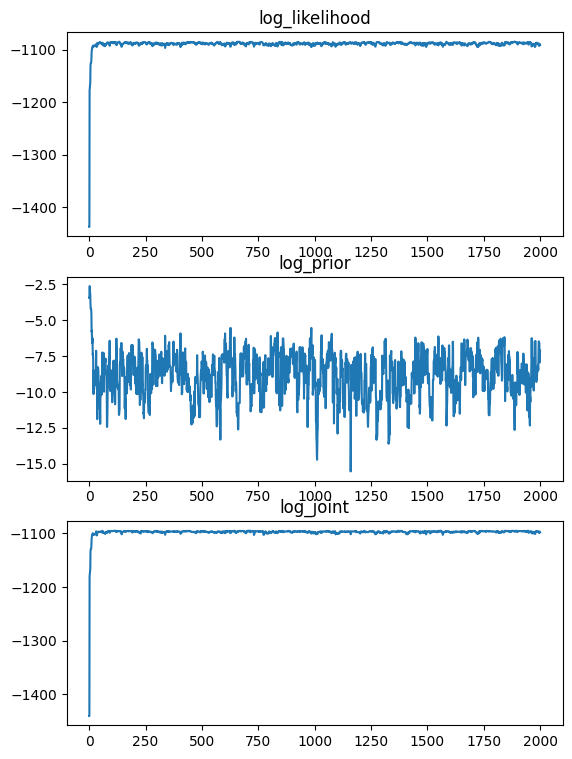

In [16]:
fig, axes = plt.subplots(len(stats))
fig.set_figheight(9)

for ax, stat in zip(axes, stats):
    sns.lineplot(stats[stat], ax=ax)
    ax.set_title(stat)

plt.show()

## Summaries

In [17]:
summary = defaultdict(list)

for param in sorted(posterior_samples.keys()):
    summary["Parameter"].append(param)
    summary["Total samples"].append(len(posterior_samples[param]))

    try:
        summary["ESS"].append(estimate_ess(posterior_samples[param]).item())
    except:
        # A parameter is probably fixed, so the posterior is a point mass
        summary["ESS"].append(np.nan)

    summary["Acceptance ratio"].append(
        np.mean(posterior_samples[param][:-1] != posterior_samples[param][1:])
    )
    summary["Prior mean"].append(prior_samples[param].mean())
    summary["Posterior mean"].append(posterior_samples[param].mean())

pd.DataFrame(summary).round(2).set_index("Parameter")

/Users/thanasibakis/GitHub/gcdyn/.venv/lib/python3.9/site-packages/mcmc_diagnostics/ar_model.py:127: RuntimeWarning: divide by zero encountered in log


,Total samples,ESS,Acceptance ratio,Prior mean,Posterior mean
Parameter,,,,,
death_rate,2001,235.76,0.70400006,1.1532,0.04
xscale,2001,141.48,0.14500001,2.001515,2.39
xshift,2001,103.74,0.15650001,4.9892,5.51
yscale,2001,112.81,0.087000005,2.011464,1.26
yshift,2001,NaN,0.0,0.5,0.50


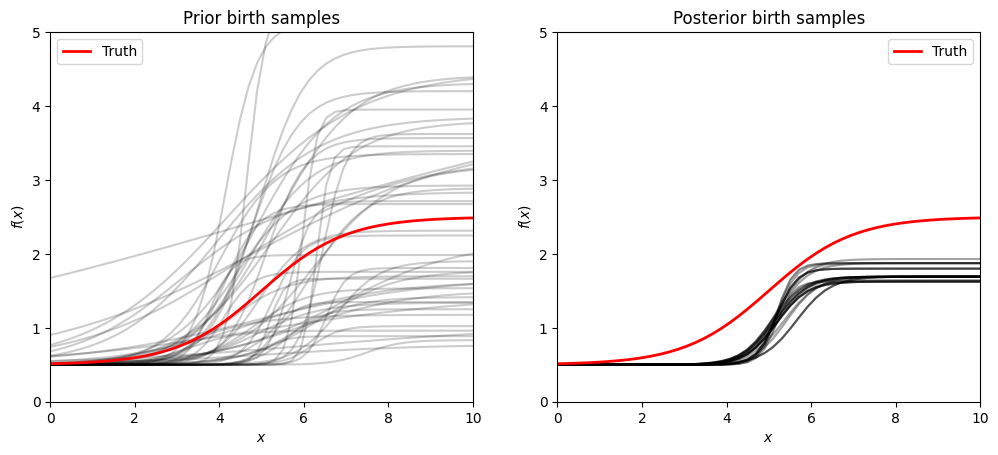

In [18]:
x_array = np.linspace(0, 10)

fig, axes = plt.subplots(1, 2)

for samples, ax in zip((prior_samples, posterior_samples), axes):
    birth_responses = []

    for i in range(len(samples["xscale"]) - 50, len(samples["xscale"])):
        response = poisson.SigmoidResponse(
            xscale=samples["xscale"][i].item(),
            xshift=samples["xshift"][i].item(),
            yscale=samples["yscale"][i].item(),
            yshift=true_parameters["birth_response"].yshift,
            # yshift=samples["yshift"][i].item(),
        )

        birth_responses.append(response)

    for response in birth_responses:
        ax.plot(x_array, response.λ_phenotype(x_array), color="black", alpha=0.2)

    ax.plot(
        x_array,
        true_parameters["birth_response"].λ_phenotype(x_array),
        label="Truth",
        linewidth=2,
        color="red",
    )

    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$f(x)$")
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 5)
    ax.legend()

axes[0].set_title("Prior birth samples")
axes[1].set_title("Posterior birth samples")
fig.set_figwidth(12)
plt.show()

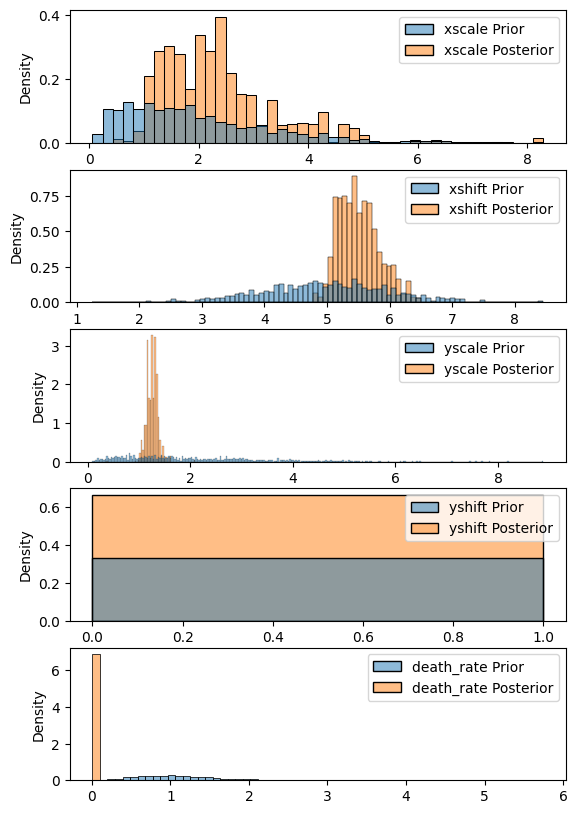

In [19]:
fig, axes = plt.subplots(len(posterior_samples), 1)
fig.set_figheight(10)

for ax, param in zip(axes, posterior_samples):
    s = {
        f"{param} Prior": prior_samples[param],
        f"{param} Posterior": posterior_samples[param],
    }

    sns.histplot(s, ax=ax, stat="density")